 # create Dataset with 3s long samples

In [18]:
# Dependencies

 # TensorFlow and tf.keras
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)
from tensorflow import keras

# Helper libraries
import os
import os.path
import glob
import librosa
import librosa.display
from librosa.display import waveshow
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as pd
import pprint
import random
import time

# Check if the GPU is available
print("GPU", "available, YES" if tf.config.list_physical_devices("GPU") else "no GPU")



Tensorflow Version: 2.13.0
GPU available, YES


In [19]:
# load global settings in config-dictionary
with open('./MA_CONFIG.json', 'r') as fp:
  config = json.load(fp)


# set sr
config['sr'] = 44100
config['shift_samples'] = int((441/44100) * config['sr']) # 441 samples bei 44100 Hz


# print config
print(json.dumps(config, indent=4))

# save config to disk
with open('./MA_CONFIG.json', 'w+') as fp:
    json.dump(config, fp, sort_keys=True, indent=4)


{
    "activation_func": "tanh",
    "batch_size": 16,
    "dropout_rate": 0.5,
    "filter_size": 64,
    "fps_noisy": "/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/noisySpeech",
    "fps_produced": "/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/producedSpeech",
    "fps_voicefixer": "/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/voicefixerOutput",
    "hop_length": 64,
    "input_shape": [
        132300,
        1
    ],
    "kernel_size": 5,
    "learning_rate": 0.002,
    "n_epochs": 20,
    "n_fft": 512,
    "n_mels": 16,
    "offset": 6,
    "sample_length": 20,
    "shift_samples": 441,
    "shuffle_buffer_size": 300,
    "sr": 44100,
    "test_dataset_path": "../Dataset/test.tfrecord",
    "train_dataset_path": "../Dataset/train.tfrecord",
    "win_length": 512
}


# func to save dataset to tfrecords of ~100mb

In [24]:
def load_and_process_data(file_path):

    # load audio data 
    voicefixer, _ = librosa.load(file_path, sr=config['sr'], mono=True, offset=0.0, duration=None, 
                             dtype=np.float32, res_type='kaiser_fast')
    
    
    # # paths for ground truths prod files
    fps_prod = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/producedSpeech/*.wav')
    
    # get string with speaker and scriptname
    label = file_path.split('/')[-1]
    label = label[:11]
    for filename in fps_prod:
        if label in filename:
            fp = filename
            break

    #fp = '/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/DAPS/produced/f1_script1_produced.wav'


    # load corresponding produced audio file
    produced, _ = librosa.load(fp, sr=config['sr'], mono=True, offset=0.0, duration=None, 
                             dtype=np.float32, res_type='kaiser_fast')
    
    # # align audio signals
    # y = np.concatenate((np.zeros(int(config['shift_samples'])), y[:-int(config['shift_samples'])]))

    # cut audio into 3s frames
    seg = 3*int(config['sr'])
    voicefixer_3s = librosa.util.frame(voicefixer, frame_length=seg, hop_length=seg).T
    produced_3s = librosa.util.frame(produced, frame_length=seg, hop_length=seg).T    

    # # get shape
    # print('y_3s.shape:', y_3s.shape)
    # print('produced_3s.shape:', produced_3s.shape)

    return voicefixer_3s, produced_3s


def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


# tfrecords writer
def save_tfrecords(tfrecords_path: str,
                   voicefixer_list: list,
                   produced_list: list,
                   config: dict):

    # tfrecords writer
    with tf.io.TFRecordWriter(tfrecords_path) as writer:
        for v_array, p_array in zip(voicefixer_list, produced_list):

            # encode
            v_encoded = tf.audio.encode_wav(v_array[:, np.newaxis], config['sr'])
            p_encoded = tf.audio.encode_wav(p_array[:, np.newaxis], config['sr'])
        
            # save feature
            feature = {'voicefixer': _bytes_feature(v_encoded),
                       'produced': _bytes_feature(p_encoded)}
            features = tf.train.Features(feature=feature)
            example = tf.train.Example(features=features)
            writer.write(example.SerializeToString())


        # close writer
        writer.close()

# Save Train Dataset

In [19]:
# folder with the training data
train_files = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train/*.wav')

voicefixer_list = []
produced_list = []

# for 3s files
length_tf_records = 180 # ~100mb
sr = config['sr']


i=0
for idx, file in enumerate(train_files):
    voicefixer, produced = load_and_process_data(file)
    voicefixer_list.extend(voicefixer)
    produced_list.extend(produced)
    print(len(voicefixer_list), len(produced_list))

    if len(voicefixer_list) > (length_tf_records):
        save_tfrecords(f'/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train_tfrecords/train_{i}_{sr}_Hz.tfrecords', voicefixer_list[:length_tf_records], produced_list[:length_tf_records], config)
        voicefixer_list = voicefixer_list[length_tf_records:]
        produced_list = produced_list[length_tf_records:]
        i=i+1
        print(f'tfrecord #{i} saved')



48 48
112 112
164 164
215 215
tfrecord #1 saved
84 84
147 147
201 201
tfrecord #2 saved
87 87
140 140
202 202
tfrecord #3 saved
62 62
119 119
181 181
tfrecord #4 saved
63 63
116 116
165 165
216 216
tfrecord #5 saved
91 91
147 147
200 200
tfrecord #6 saved
64 64
121 121
180 180
220 220
tfrecord #7 saved
81 81
147 147
192 192
tfrecord #8 saved
66 66
120 120
183 183
tfrecord #9 saved
62 62
125 125
169 169
215 215
tfrecord #10 saved
88 88
142 142
193 193
tfrecord #11 saved
68 68
129 129
188 188
tfrecord #12 saved
63 63
115 115
170 170
228 228
tfrecord #13 saved
107 107
162 162
220 220
tfrecord #14 saved
97 97
153 153
208 208
tfrecord #15 saved
77 77
130 130
192 192
tfrecord #16 saved
59 59
110 110
158 158
217 217
tfrecord #17 saved
101 101
167 167
226 226
tfrecord #18 saved
97 97
158 158
202 202
tfrecord #19 saved
78 78
125 125
177 177
226 226
tfrecord #20 saved
91 91
132 132
184 184
tfrecord #21 saved
50 50
102 102
165 165
224 224
tfrecord #22 saved
89 89
148 148
199 199
tfrecord #23 save

# Save test Dataset

In [ ]:
# folder with the training data
test_files = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/test/*.wav')

voicefixer_list = []
produced_list = []

# for 3s files
length_tf_records = 180 # ~100mb
sr = config['sr']

i=0
for idx, file in enumerate(test_files):
    voicefixer, produced = load_and_process_data(file)
    voicefixer_list.extend(voicefixer)
    produced_list.extend(produced)
    print(len(voicefixer_list), len(produced_list))

    if len(voicefixer_list) > (length_tf_records):
        save_tfrecords(f'/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/test_tfrecords/test__{i}_{sr}_Hz.tfrecords', voicefixer_list[:length_tf_records], produced_list[:length_tf_records], config)
        voicefixer_list = voicefixer_list[length_tf_records:]
        produced_list = produced_list[length_tf_records:]
        i=i+1
        print(f'tfrecord #{i} saved')



# Save valid Dataset

In [25]:
# folder with the training data
valid_files = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/valid/*.wav')

voicefixer_list = []
produced_list = []

# for 3s files
length_tf_records = 180 # ~100mb
sr = config['sr']

i=0
for idx, file in enumerate(valid_files):
    voicefixer, produced = load_and_process_data(file)
    voicefixer_list.extend(voicefixer)
    produced_list.extend(produced)
    print(len(voicefixer_list), len(produced_list))

    if len(voicefixer_list) > (length_tf_records):
        save_tfrecords(f'/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/valid_tfrecords/valid__{i}_{sr}_Hz.tfrecords', voicefixer_list[:length_tf_records], produced_list[:length_tf_records], config)
        voicefixer_list = voicefixer_list[length_tf_records:]
        produced_list = produced_list[length_tf_records:]
        i=i+1
        print(f'tfrecord #{i} saved')
    


64 64
111 111
177 177
234 234
tfrecord #1 saved
111 111
169 169
235 235
tfrecord #2 saved
119 119
193 193
tfrecord #3 saved
70 70
128 128
202 202
tfrecord #4 saved
75 75
122 122
186 186
tfrecord #5 saved
72 72
119 119
193 193
tfrecord #6 saved
66 66
130 130
204 204
tfrecord #7 saved
81 81
141 141
205 205
tfrecord #8 saved
91 91
155 155
213 213
tfrecord #9 saved
97 97
171 171
228 228
tfrecord #10 saved
95 95
153 153
219 219
tfrecord #11 saved
113 113
177 177
234 234
tfrecord #12 saved
111 111
158 158
205 205
tfrecord #13 saved
89 89
142 142
202 202
tfrecord #14 saved
75 75
132 132
185 185
tfrecord #15 saved
71 71
135 135
188 188
tfrecord #16 saved
68 68
126 126
190 190
tfrecord #17 saved
57 57
117 117
175 175
241 241
tfrecord #18 saved
108 108
182 182
tfrecord #19 saved
66 66
119 119
193 193
tfrecord #20 saved
73 73
126 126
192 192
tfrecord #21 saved
70 70
128 128
202 202
tfrecord #22 saved
80 80
144 144
208 208
tfrecord #23 saved
86 86
143 143
201 201
tfrecord #24 saved
68 68
125 125
1

# Check the Data by plot and audio display

In [16]:
# audio conversion
def float2pcm(sig, dtype='int16'):
    sig = np.asarray(sig)
    if sig.dtype.kind != 'f':
        raise TypeError("'sig' must be a float array")
    dtype = np.dtype(dtype)
    if dtype.kind not in 'iu':
        raise TypeError("'dtype' must be an integer type")

    i = np.iinfo(dtype)
    abs_max = 2 ** (i.bits - 1)
    offset = i.min + abs_max
    return (sig * abs_max + offset).clip(i.min, i.max).astype(dtype)

(132300, 1) (132300, 1)
float32 float32


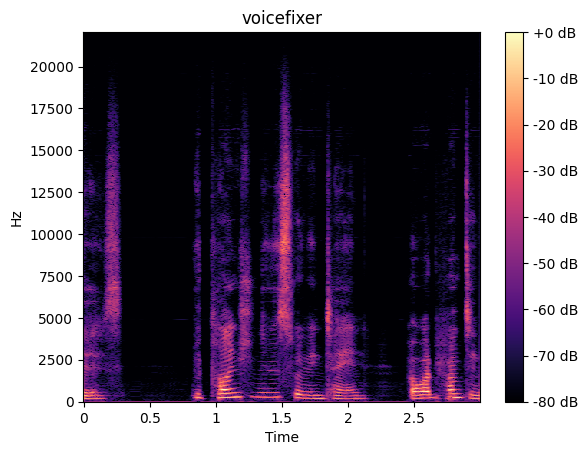

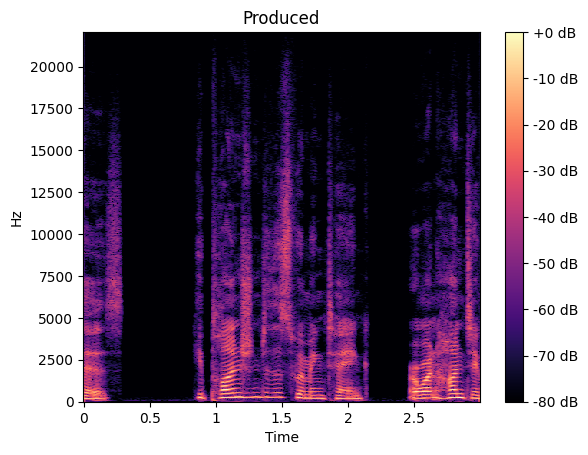

In [31]:
import os
from scipy.io.wavfile import write
import helpers
from helpers import decode_tf_records
import librosa

AUTOTUNE = tf.data.experimental.AUTOTUNE

# load tf records
path = '/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train_tfrecords/'
dataset = tf.data.TFRecordDataset(os.path.join(path, 'train_201_44100_Hz.tfrecords'))
dataset = dataset.map(decode_tf_records, num_parallel_calls=AUTOTUNE)


dataset = dataset.as_numpy_iterator()
for i, sample in enumerate(dataset):

    wav_VF = sample[0]
    wav_P = sample[1]

    # get shape
    print(wav_VF.shape, wav_P.shape)
    # get dtype
    print(wav_VF.dtype, wav_P.dtype)


    V = np.abs(librosa.stft(np.transpose(wav_VF), n_fft=2048, hop_length=256, win_length=2048))
    P = np.abs(librosa.stft(np.transpose(wav_P), n_fft=2048, hop_length=256, win_length=2048))

    # convert to db
    voicefixer = librosa.amplitude_to_db(np.abs(V), ref=np.max)
    produced = librosa.amplitude_to_db(np.abs(P), ref=np.max)


    # plot
    librosa.display.specshow(data = np.squeeze(voicefixer), sr = 44100, hop_length=256, y_axis='linear', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('voicefixer')
    plt.show()

    librosa.display.specshow(data = np.squeeze(produced), sr =44100, hop_length=256, y_axis='linear', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Produced')
    plt.show()

    
    write('./3_Voicefixer.wav', int(44100), float2pcm(wav_VF))
    write('./3_produced.wav', int(44100), float2pcm(wav_P))

    break

In [ ]:
# # look at some example data from train dataset
# wavs = train_dataset.as_numpy_iterator()
# noisy = []
# gt = []

# # Setup Subplot
# nrows, ncols = 2, 2
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 9))


# # iterate over dataset
# for i, sample in enumerate(wavs):
    
#     # get the column and row by modulo and remainder
#     j = i % ncols
#     k = int(i / ncols)
    
#     # extract noisy and produced speech file from tensors
#     wave = sample[0]
#     ground_truth = sample[1]
        
#     # plot files
#     librosa.display.waveshow(np.squeeze(wave), x_axis='time', sr=config['sr'], ax=ax[k][j], label='test_file')
#     librosa.display.waveshow(np.squeeze(ground_truth), alpha=0.3, x_axis='time', sr=config['sr'], ax=ax[k][j], label='ground_truth')
#     ax[k][j].legend()
#     ax[k][j].axis('on')
#     ax[k][j].set_title('10s speech')  

#     # save speech to arrays
#     noisy.append(np.squeeze(wave))
#     gt.append(np.squeeze(ground_truth))
    
#     if i+1 == ncols*nrows:
#         break
    
# # adjust whitespace in between subplots        
# plt.subplots_adjust(hspace=0.25, wspace=0.15)
# plt.show()


# # listen to the audio samples
# for i in range(len(gt)):
#     print(f'----------- {i+1}. speechsnippet ---------------')
#     print('')
#     print(f'Voicefixer file')
#     pd.display(pd.Audio(noisy[i].T, rate=config['sr']))
#     print(f'corresponding produced file')
#     pd.display(pd.Audio(gt[i].T, rate=config['sr']))
#     print('')
